In [1]:
import os
import csv
import pandas as pd
import numpy as np
#
import collections
from collections import defaultdict, OrderedDict
import queue as Q
#
import matplotlib.pyplot as plt
#

In [2]:
# Definimos algunas funciones

In [3]:
def compute_at_backend(q):
    return query_costs[q]

##### Las siguientes funciones de gestion de un cache (con una política) son demostrativas y no están impementadas con criterios de eficiencia.

In [4]:
class LRUCache:
    def __init__(self, size):
        self.size = size
        self.lru_cache = collections.OrderedDict()
    def get(self, key):
        try:
            value = self.lru_cache.pop(key)
            self.lru_cache[key] = value
            return value
        except KeyError:
            return -1
    def put(self, key, value):
        try:
            self.lru_cache.pop(key)
        except KeyError:
            if len(self.lru_cache) >= self.size:
                self.lru_cache.popitem(last=False)
            self.lru_cache[key] = value
    def dump_cache(self):
        print (self.lru_cache)

In [5]:
class LFUCache:
    def __init__(self, capacity):
        self.remain = capacity
        self.least_freq = 1
        self.node_for_freq = collections.defaultdict(collections.OrderedDict)
        self.node_for_key = dict()
    def _update(self, key, value):
        _, freq = self.node_for_key[key]
        self.node_for_freq[freq].pop(key)
        if len(self.node_for_freq[self.least_freq]) == 0:
            self.least_freq += 1
        self.node_for_freq[freq+1][key] = (value, freq+1)
        self.node_for_key[key] = (value, freq+1)
    def get(self, key):
        if key not in self.node_for_key:
            return -1
        value = self.node_for_key[key][0]
        self._update(key, value)
        return value
    def put(self, key, value):
        if key in self.node_for_key:
            self._update(key, value)
        else:
            self.node_for_key[key] = (value,1)
            self.node_for_freq[1][key] = (value,1)
            if self.remain == 0:
                try:
                    removed = self.node_for_freq[self.least_freq].popitem(last=False)
                    self.node_for_key.pop(removed[0])
                except:
                    pass
            else:
                self.remain -= 1
                self.least_freq = 1
                #
    def dump(self):
        print (self.node_for_freq)

In [6]:
class FxCCache:
    def __init__(self, capacity):
        self.remain = capacity
        self.item_fxcq  = Q.PriorityQueue()     # (fxc, key)
        self.item_valid = dict()                # Para una key, guarda el fxc válido
        self.item_freq  = dict()                # Frecuencia de key
        self.item_cost  = dict()                # Costo de key
    #
    def dump_freq(self):
        print (self.item_freq)
    #
    def dump_queue(self):
        tmp = Q.PriorityQueue() # (fxc, key)
        while not self.item_fxcq.empty():
            it = self.item_fxcq.get()
            print (it, end = ' '),
            tmp.put(it)
        print ()
        self.item_fxcq = tmp
    #
    def _update(self, key):
        self.item_freq[key] += 1
        fxc = (self.item_freq[key]) * self.item_cost[key]
        self.item_valid[key] = fxc
        self.item_fxcq.put((fxc, key))
        #print (fxc)
        return fxc
    
    def get(self, key):
        if key not in self.item_freq:
            return -1
        up = self._update(key)       # Tengo que freq+=1 y actualizar fx en la cola
        return up

    #
    def put(self, key, cost):
        if key in self.item_freq:
            self._update(key) # Tengo que freq+=1 y actualizar fxc en la cola
        else:
            self.item_freq[key] = 1
            self.item_cost[key] = cost
            fxc = cost
            #
            if self.remain == 0:
                while True:
                    remove = self.item_fxcq.get()
                    rkey = remove[1]
                    valid_fxc = self.item_valid[rkey]
                    if remove[0] == valid_fxc:
                        try:
                            del(self.item_freq[rkey])
                            del(self.item_cost[rkey])
                        except:
                            pass
                        break
            else:
                self.remain -= 1
            # El item lo inserto despues de remover el menor
            self.item_fxcq.put((fxc, key))
            self.item_valid[key] = fxc

---
### MAIN
---

In [7]:
# Se carga en un diccionario el costo de los queries del log para simular el tiempo de cómputo en el 
# back end. Este diccionario es utilizado por la función 'compute_at_backend(q)'
query_costs = {}
with open("../data/AOL_360k_sample.unique.times", "r") as fin:
    for line in fin:
        q, t = line.strip().split(",")
        query_costs[q] = float(t)

In [8]:
# Se lee el archivo de consultas (completo) y se generan dos listas con los queries y costos, 
# respectivamente. Éstas se van a usar para la simulación de la performance de las politicas 
# de cache y para calcular estadísticas básicas.queries_to_process = []
queries_to_process = []
times_to_process = []
#
with open("../data/AOL_360k_sample.txt", "r") as fin:
    for query in fin:
        query = query.strip()
        cost = compute_at_backend(query)
        #
        queries_to_process.append(query)
        times_to_process.append(cost)
    #
total_queries = len(queries_to_process)

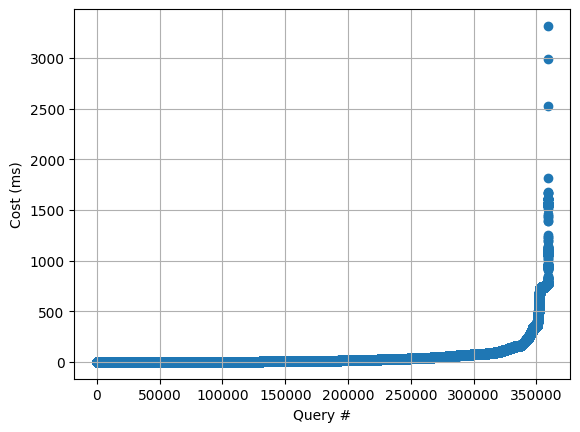

In [9]:
# Graficamos los costos de los queries
y_axis = sorted(times_to_process)
x_axis = range(0, len(y_axis))
#x_axis = [x / total_queries for x in x_axis]   # Eje-x como proporción del total
#
plt.scatter(x_axis, y_axis)
plt.grid()
plt.xlabel("Query #")
plt.ylabel("Cost (ms)")
plt.show()

In [10]:
# Estadísticas de costos del set de queries
total_time = sum(times_to_process)
mean_time  = np.mean(times_to_process)
p90_time   = np.percentile(times_to_process, 90)
p99_time   = np.percentile(times_to_process, 99)
max_time   = max(times_to_process)

In [11]:
print (f'Cantidad de queries: {total_queries}')
print (f'Tiempo total       : {total_time:.2f} ms')
print (f'Tiempo medio       : {mean_time:.2f} ms')
print (f'Tiempo P90 (tail)  : {p90_time:.2f} ms')
print (f'Tiempo P99 (tail)  : {p99_time:.2f} ms')
print (f'Tiempo Máximo P100): {max_time:.2f} ms')

Cantidad de queries: 359168
Tiempo total       : 18025987.30 ms
Tiempo medio       : 50.19 ms
Tiempo P90 (tail)  : 110.78 ms
Tiempo P99 (tail)  : 741.30 ms
Tiempo Máximo P100): 3317.14 ms


**Tarea 1: Probar LRU con el ejemplo de las diapos**

In [12]:
mycache = LRUCache(3)

In [13]:
mycache.put(1, "A")
mycache.put(2, "B")
mycache.put(3, "C")
mycache.dump_cache()

OrderedDict([(1, 'A'), (2, 'B'), (3, 'C')])


In [14]:
mycache.get(2)
mycache.dump_cache()

OrderedDict([(1, 'A'), (3, 'C'), (2, 'B')])


In [15]:
mycache.get(4)

-1

In [16]:
mycache.put(4, "D")
mycache.dump_cache()

OrderedDict([(3, 'C'), (2, 'B'), (4, 'D')])


In [17]:
mycache.get(3)
mycache.dump_cache()

OrderedDict([(2, 'B'), (4, 'D'), (3, 'C')])


In [18]:
mycache.put(1, "A")
mycache.dump_cache()

OrderedDict([(4, 'D'), (3, 'C'), (1, 'A')])


In [19]:
mycache.get(3)
mycache.dump_cache()

OrderedDict([(4, 'D'), (1, 'A'), (3, 'C')])


#### Hit Rate

**Tarea 2: Evaluar Hit rate para diferentes tamaños de cache**

In [20]:
cache_sizes = [1000, 5000, 10000, 25000, 50000, 75000, 100000]

In [21]:
# Itero sobre los tamaños de cache a evaluar
LRU_hit_ratios = []
for csize in cache_sizes:
    mycache = LRUCache(csize)
    #
    hits   = 0
    misses = 0
    for query in queries_to_process:
        if mycache.get(query) != -1:
            hits+=1
        else:
            mycache.put(query, "dummy")
            misses+=1
    hit_ratio = hits / (hits+misses)
    LRU_hit_ratios.append(hit_ratio)
    print (f'Cache size {csize}, hits: {hits}, misses: {misses}, Hit ratio: {hit_ratio:.3f}')

Cache size 1000, hits: 22904, misses: 336264, Hit ratio: 0.064
Cache size 5000, hits: 39505, misses: 319663, Hit ratio: 0.110
Cache size 10000, hits: 49220, misses: 309948, Hit ratio: 0.137
Cache size 25000, hits: 63879, misses: 295289, Hit ratio: 0.178
Cache size 50000, hits: 76102, misses: 283066, Hit ratio: 0.212
Cache size 75000, hits: 82870, misses: 276298, Hit ratio: 0.231
Cache size 100000, hits: 87344, misses: 271824, Hit ratio: 0.243


In [22]:
# Itero sobre los tamaños de cache a evaluar
LFU_hit_ratios = []
for csize in cache_sizes:
    mycache = LFUCache(csize)
    #
    hits   = 0
    misses = 0
    for query in queries_to_process:
        if mycache.get(query) != -1:
            hits+=1
        else:
            mycache.put(query, "dummy")
            misses+=1
    hit_ratio = hits / (hits+misses)
    LFU_hit_ratios.append(hit_ratio)
    print (f'Cache size {csize}, hits: {hits}, misses: {misses}, Hit ratio: {hit_ratio:.3f}')

Cache size 1000, hits: 46271, misses: 312897, Hit ratio: 0.129
Cache size 5000, hits: 55820, misses: 303348, Hit ratio: 0.155
Cache size 10000, hits: 63163, misses: 296005, Hit ratio: 0.176
Cache size 25000, hits: 73624, misses: 285544, Hit ratio: 0.205
Cache size 50000, hits: 81759, misses: 277409, Hit ratio: 0.228
Cache size 75000, hits: 86373, misses: 272795, Hit ratio: 0.240
Cache size 100000, hits: 89408, misses: 269760, Hit ratio: 0.249


In [23]:
# Itero sobre los tamaños de cache a evaluar
FxC_hit_ratios = []
for csize in cache_sizes:
    mycache = FxCCache(csize)
    #
    hits   = 0
    misses = 0
    for query in queries_to_process:
        if mycache.get(query) != -1:
            hits+=1
        else:
            mycache.put(query, compute_at_backend(query))
            misses+=1
    hit_ratio = hits / (hits+misses)
    FxC_hit_ratios.append(hit_ratio)
    print (f'Cache size {csize}, hits: {hits}, misses: {misses}, Hit ratio: {hit_ratio:.3f}')

Cache size 1000, hits: 20028, misses: 339140, Hit ratio: 0.056
Cache size 5000, hits: 32550, misses: 326618, Hit ratio: 0.091
Cache size 10000, hits: 40204, misses: 318964, Hit ratio: 0.112
Cache size 25000, hits: 52884, misses: 306284, Hit ratio: 0.147
Cache size 50000, hits: 65987, misses: 293181, Hit ratio: 0.184
Cache size 75000, hits: 74542, misses: 284626, Hit ratio: 0.208
Cache size 100000, hits: 80996, misses: 278172, Hit ratio: 0.226


In [24]:
# Plot

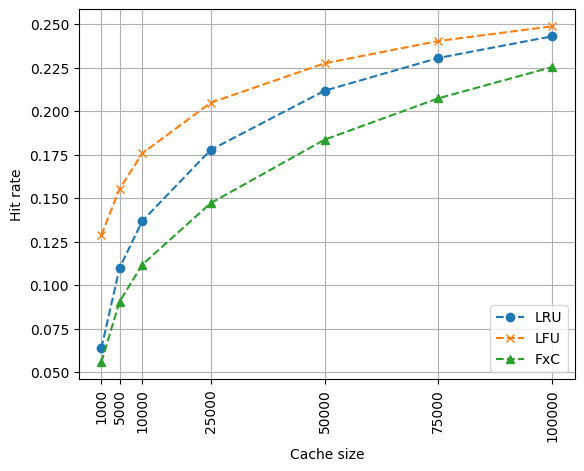

In [25]:
plt.plot(cache_sizes, LRU_hit_ratios, 'o--', markersize=6, label="LRU")
plt.plot(cache_sizes, LFU_hit_ratios, 'x--', markersize=6, label="LFU")
plt.plot(cache_sizes, FxC_hit_ratios, '^--', markersize=6, label="FxC")
#
plt.grid()
plt.xlabel("Cache size")
plt.ylabel("Hit rate")
#
locs, labels = plt.xticks(cache_sizes, rotation=90)
plt.legend(loc=4)
plt.show()

**Tarea 3: Evaluar costo total para diferentes tamaños de cache**

In [26]:
# Itero sobre los tamaños de cache a evaluar
LRU_total_costs = []
for csize in cache_sizes:
    mycache = LRUCache(csize)
    #
    hits   = 0
    misses = 0
    #
    cost   = 0
    total_cost   = 0
    #
    for query in queries_to_process:
        if mycache.get(query) != -1:
            cost = 0
            hits+=1
        else:
            cost = compute_at_backend(query)
            mycache.put(query, "dummy")
            misses+=1
        total_cost += cost    
    LRU_total_costs.append(total_cost)
    print (f'Cache size {csize}, hits: {hits}, misses: {misses}, Total cost: {total_cost:.3f}')

Cache size 1000, hits: 22904, misses: 336264, Total cost: 16140372.942
Cache size 5000, hits: 39505, misses: 319663, Total cost: 15180631.787
Cache size 10000, hits: 49220, misses: 309948, Total cost: 14736855.915
Cache size 25000, hits: 63879, misses: 295289, Total cost: 14085141.287
Cache size 50000, hits: 76102, misses: 283066, Total cost: 13563703.466
Cache size 75000, hits: 82870, misses: 276298, Total cost: 13269436.361
Cache size 100000, hits: 87344, misses: 271824, Total cost: 13075905.305


In [27]:
# Itero sobre los tamaños de cache a evaluar
LFU_total_costs = []
for csize in cache_sizes:
    mycache = LFUCache(csize)
    #
    hits   = 0
    misses = 0
    #
    cost   = 0
    total_cost   = 0
    #
    for query in queries_to_process:
        if mycache.get(query) != -1:
            cost = 0
            hits+=1
        else:
            cost = compute_at_backend(query)
            mycache.put(query, "dummy")
            misses+=1
        total_cost += cost    
    LFU_total_costs.append(total_cost)
    print (f'Cache size {csize}, hits: {hits}, misses: {misses}, Total cost: {total_cost:.3f}')

Cache size 1000, hits: 46271, misses: 312897, Total cost: 14857213.433
Cache size 5000, hits: 55820, misses: 303348, Total cost: 14390617.562
Cache size 10000, hits: 63163, misses: 296005, Total cost: 14083138.950
Cache size 25000, hits: 73624, misses: 285544, Total cost: 13643750.437
Cache size 50000, hits: 81759, misses: 277409, Total cost: 13311807.388
Cache size 75000, hits: 86373, misses: 272795, Total cost: 13128680.665
Cache size 100000, hits: 89408, misses: 269760, Total cost: 12995116.587


In [28]:
# Itero sobre los tamaños de cache a evaluar
FxC_total_costs = []
for csize in cache_sizes:
    mycache = FxCCache(csize)
    #
    hits   = 0
    misses = 0
    #
    cost   = 0
    total_cost   = 0
    #
    for query in queries_to_process:
        if mycache.get(query) != -1:
            cost = 0
            hits+=1
        else:
            cost = compute_at_backend(query)
            mycache.put(query, cost)
            misses+=1
        total_cost += cost    
    FxC_total_costs.append(total_cost)
    print (f'Cache size {csize}, hits: {hits}, misses: {misses}, Total cost: {total_cost:.3f}')

Cache size 1000, hits: 20028, misses: 339140, Total cost: 15213647.618
Cache size 5000, hits: 32550, misses: 326618, Total cost: 14141614.470
Cache size 10000, hits: 40204, misses: 318964, Total cost: 13612200.088
Cache size 25000, hits: 52884, misses: 306284, Total cost: 13118606.303
Cache size 50000, hits: 65987, misses: 293181, Total cost: 12878837.997
Cache size 75000, hits: 74542, misses: 284626, Total cost: 12786604.445
Cache size 100000, hits: 80996, misses: 278172, Total cost: 12748311.781


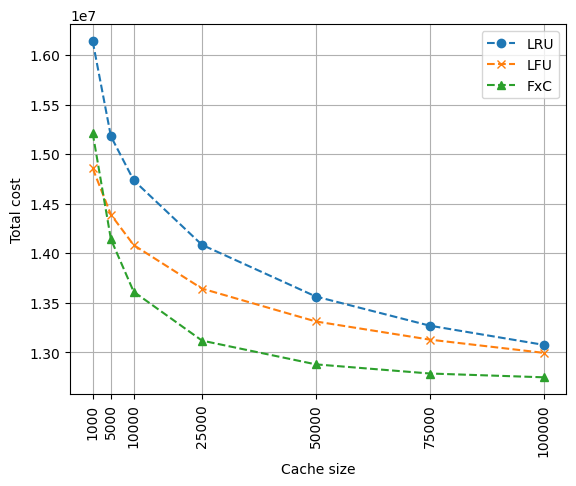

In [29]:
plt.plot(cache_sizes, LRU_total_costs, 'o--', markersize=6, label="LRU")
plt.plot(cache_sizes, LFU_total_costs, 'x--', markersize=6, label="LFU")
plt.plot(cache_sizes, FxC_total_costs, '^--', markersize=6, label="FxC")
#
plt.grid()
plt.xlabel("Cache size")
plt.ylabel("Total cost")
#
locs, labels = plt.xticks(cache_sizes, rotation=90)
plt.legend(loc=1)
plt.show()

**Tarea 4: Calcular Ahorro entre FxC y LFU**

In [30]:
# ToDo

**Evaluo LRU con WarmUp**

In [31]:
# Itero sobre los tamaños de cache a evaluar
LRU_wu_hit_ratios = []
for csize in cache_sizes:
    mycache = LRUCache(csize)
    #
    warmup_queries = csize   
    #
    hits   = 0
    misses = 0
    for i, query in enumerate(queries_to_process):
        if mycache.get(query) != -1:
            if i > warmup_queries:
                hits+=1
        else:
            mycache.put(query, "dummy")
            if i > warmup_queries:
                misses+=1
    hit_ratio = hits / (hits+misses)
    LRU_wu_hit_ratios.append(hit_ratio)
    print (f'Cache size {csize}, hits: {hits}, misses: {misses}, Hit ratio: {hit_ratio:.3f}')

Cache size 1000, hits: 22855, misses: 335312, Hit ratio: 0.064
Cache size 5000, hits: 39066, misses: 315101, Hit ratio: 0.110
Cache size 10000, hits: 48119, misses: 301048, Hit ratio: 0.138
Cache size 25000, hits: 60367, misses: 273800, Hit ratio: 0.181
Cache size 50000, hits: 67842, misses: 241325, Hit ratio: 0.219
Cache size 75000, hits: 69007, misses: 215160, Hit ratio: 0.243
Cache size 100000, hits: 67451, misses: 191716, Hit ratio: 0.260


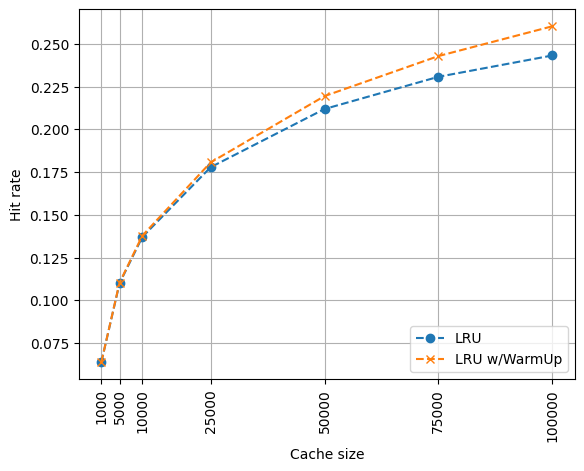

In [32]:
plt.plot(cache_sizes, LRU_hit_ratios, 'o--', markersize=6, label="LRU")
plt.plot(cache_sizes, LRU_wu_hit_ratios, 'x--', markersize=6, label="LRU w/WarmUp")
#
plt.grid()
plt.xlabel("Cache size")
plt.ylabel("Hit rate")
#
locs, labels = plt.xticks(cache_sizes, rotation=90)
plt.legend(loc=4)
plt.show()

**Tarea 5: Evaluar LRU con una política de admisión basada en singletons**

In [33]:
singletons = {}
with open("../data/AOL_360k_sample.singletons", "r") as fin:
    for sing in fin:
        sing = sing.strip()
        singletons[sing] = 1
    #
print (f'Se leyeron {len(singletons)} singletons')

Se leyeron 241129 singletons


In [34]:
# Itero sobre los tamaños de cache a evaluar
LRU_nosing_hit_ratios = []
for csize in cache_sizes:
    mycache = LRUCache(csize)
    #
    hits   = 0
    misses = 0
    for query in queries_to_process:
        if mycache.get(query) != -1:
            hits+=1
        else:
            if query not in singletons:
                mycache.put(query, "dummy")
            misses+=1
    hit_ratio = hits / (hits+misses)
    LRU_nosing_hit_ratios.append(hit_ratio)
    print (f'Cache size {csize}, hits: {hits}, misses: {misses}, Hit ratio: {hit_ratio:.3f}')

Cache size 1000, hits: 35641, misses: 323527, Hit ratio: 0.099
Cache size 5000, hits: 62066, misses: 297102, Hit ratio: 0.173
Cache size 10000, hits: 77344, misses: 281824, Hit ratio: 0.215
Cache size 25000, hits: 95845, misses: 263323, Hit ratio: 0.267
Cache size 50000, hits: 95845, misses: 263323, Hit ratio: 0.267
Cache size 75000, hits: 95845, misses: 263323, Hit ratio: 0.267
Cache size 100000, hits: 95845, misses: 263323, Hit ratio: 0.267


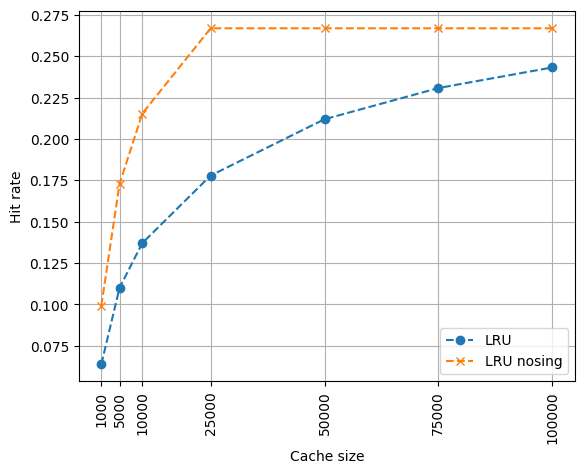

In [35]:
plt.plot(cache_sizes, LRU_hit_ratios, 'o--', markersize=6, label="LRU")
plt.plot(cache_sizes, LRU_nosing_hit_ratios, 'x--', markersize=6, label="LRU nosing")
#
plt.grid()
plt.xlabel("Cache size")
plt.ylabel("Hit rate")
#
locs, labels = plt.xticks(cache_sizes, rotation=90)
plt.legend(loc=4)
plt.show()

**Pregunta: A qué se debe el comportamiento de 'LRU nosing' en la gráfica anterior?**

**Tarea 5: Evaluar LRU con WarmUp y una política de admisión basada en singletons**

In [ ]:
# ToDo